In [2]:
# Make your plot output stored in the notebook.
%matplotlib inline

from fintextmin import *

import nltk
import pandas
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

df = pandas.read_csv('apple_jobs.csv',encoding='iso-8859-1')
df.head(10)

,title,location,minimum_qual,preferred_qual,responsibilities,education&experience
0,Software Technician,"Santa Clara Valley (Cupertino), California, Un...",2-5 years experience supporting or deploying a...,NaN,"As a software techician, you will assist with ...","AS/BS in Information Technology, or equivalent"
1,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",KEY QUALIFICATIONS\nA genuine passion for fixi...,ADDITIONAL REQUIREMENTS\nReal hands-on experie...,DESCRIPTION\nWork with multi-functional teams ...,EDUCATION\nBS or MS in Computer Engineering or...
2,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
3,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
4,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",Demonstrated experience integrating full-syste...,NaN,"Extraordinary planning, critical thinking, and...","M.S. or PhD in Computer Science, Electrical En..."
5,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",A successful track-record and proven experienc...,NaN,"We are building, and supporting new, critical ...",BS or MS in Computer Science or equivalent wor...
6,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
7,Software Engineer,"Hyderabad, Telangana, India",In-depth understanding of data structures and ...,NaN,Design and build data pipelines on MPP platfor...,Bachelor?s Degree or Equivalent with 2+ years...
8,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
9,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",2-7 years experience developing system softwar...,Experience designing SW interfaces or APIs is ...,HID Software is looking for an engineer to wor...,BS/MS in CS/CE (or equivalent)


## 1. Degree Requirements

In [2]:
def tokenize(tokenizer: nltk.tokenize.MWETokenizer, s: str, lowercase=True, preserve_case_words=[]):
    """ Tokenize given string using nltk MWETokenizer.
    :param case: convert all tokens into lowercase.
    :param exclude_words: words that should preserve their cases.
    :return: a list of tokens.
    """
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = tokenizer.tokenize(tokens)
    
    # Remove tokens that are either purely digits or purely punctuations.
    tokens = list(filter(lambda token: not token.isdigit() and re.search('[a-zA-Z]', token), tokens))

    # Since nltk MWETokenizer will not split tokens that contain a slash,
    # we'll have to do it ourselves.
    for token in tokens:
        if '/' in token:
            tokens += token.split('/')
            tokens.remove(token)
            
    # Lowercase conversion.
    tokens = [token.lower() if token not in preserve_case_words else token for token in tokens ]
            
    return tokens

In [3]:
def count_keywords_freq(df: pandas.DataFrame, col_name: str, keywords: list, none=False):
    tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
    none=False
    freq = {keyword: 0 for keyword in keywords}
    for time in range(0,len(df[col_name])):
        if type(df[col_name][time]) is not str:
            continue
        arr = tokenize(tokenizer,df[col_name][time], preserve_case_words=keywords)
        for a in arr:
            for keyword in keywords:
                if a.find(keyword) > -1:
                    freq[keyword]+=1 
    
    if none is True:
        freq['None'] = 0
        for col in df[col_name]:
            freq['None'] += 0 if type(col) is str and any(w in col for w in keywords) else 1
    return(freq)

In [4]:
keywords = ['PhD', 'Master', 'MBA', 'BA', 'BS', 'Bachelor']

# Count keyword frequency.
degree_reqs = count_keywords_freq(df, 'education&experience', keywords)

print("Education & Experience: " + str(degree_reqs))

Education & Experience: {'PhD': 247, 'Master': 127, 'MBA': 60, 'BA': 168, 'BS': 930, 'Bachelor': 308}


In [5]:
degree_df = pandas.DataFrame.from_dict(degree_reqs, orient='index', columns=['Count'])

degree_df

,Count
PhD,247
Master,127
MBA,60
BA,168
BS,930
Bachelor,308


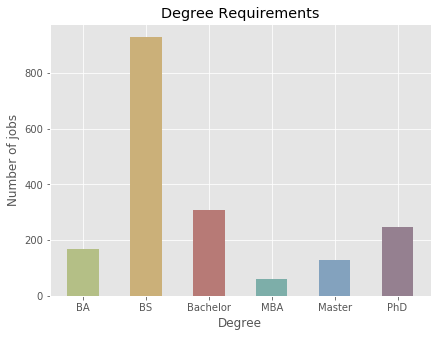

In [6]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

degree_labels = list(degree_reqs.keys())
degree_values = list(degree_reqs.values())

plt.figure(figsize=(15, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(degree_labels, degree_values, color=colors, width=0.5)
plt.xlabel('Degree')
plt.ylabel('Number of jobs')
plt.title('Degree Requirements')
plt.show()

## 2.Experience Requirements

In [7]:
def extract_experience(df: pandas.DataFrame, col_name: str, start_year=0, end_year=25):
    """ Extract years of experiences required
    :param df: target dataframe.
    :param col_name: name of the column that contains strings
                     like `4 years of experience in ...`
    :param start_year: the starting year in the list returned.
    :param end_year: the last year in the list returned.
    :return: a list of years of exp required (index by years)
    """
    import re
    
    exp_list = [0] * 26
    
    for col in df[col_name]:
        if type(col) is not str:
            continue
        exp_required = re.findall('\d+ year', col)
        exp_required =exp_required+ re.findall('\d+\+ year', col)
        year = 0 if not exp_required else int(exp_required[0].replace(' year', '').replace('+', ''))
        exp_list[year] += 1
        
    return exp_list

In [8]:
min_exp_list = extract_experience(df, 'minimum_qual')

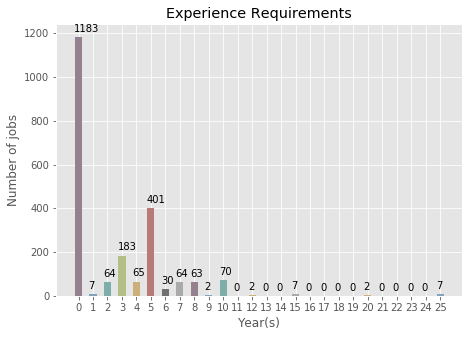

In [9]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']
labels = np.arange(len(min_exp_list))

plt.figure(figsize=(16, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(np.arange(26), min_exp_list[0:26], color=colors, width=0.5)
plt.xticks(labels[0:26])
plt.xlabel('Year(s)')
plt.ylabel('Number of jobs')
plt.title('Experience Requirements')
for i, v in enumerate(min_exp_list[0:26]):
    plt.text(i - 0.3, v+25, str(v), color='black')
plt.show()

## 3. Top 8 Job Titles

In [10]:
jobs_freq = {}

for col in df['title']:
    if type(col) is not str:
        continue
    col = col.split(',')[0]
    if col in jobs_freq:
        jobs_freq[col] += 1
    else:
        jobs_freq[col] = 1
        
jobs_freq = dict(sorted(jobs_freq.items(), key=lambda kv: kv[1], reverse=True))

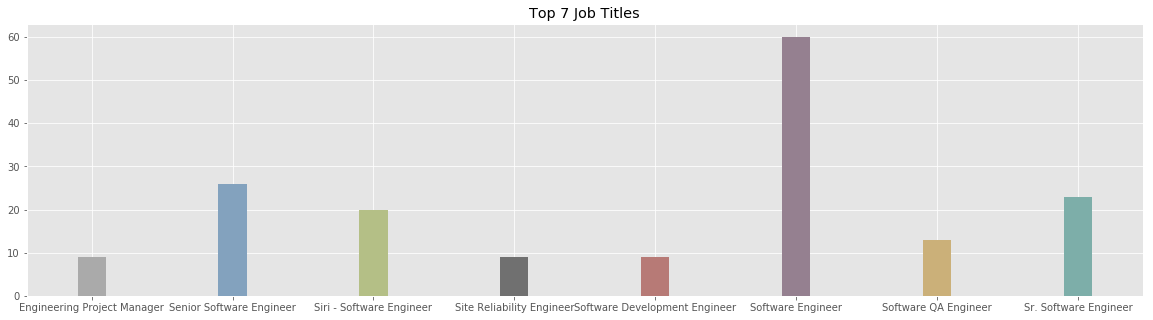

In [11]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

min_labels = list(jobs_freq.keys())[0:8]
min_values = list(jobs_freq.values())[0:8]

plt.figure(figsize=(20, 5))
plt.bar(min_labels, min_values, color=colors, width=0.2)
plt.title('Top 7 Job Titles')
plt.show()

## 4. Top 10 Programming Languages

In [12]:
lang_colors = {
    'c++': '#F34B7D',
    'java': '#B07219',
    'python': '#3572A5',
    'javascript': '#F1E05A',
    'Go': '#375EAB',
    'rust': '#DEA584',
    'php': '#4F5D95',
    'sql': '#494D5C',
    'ruby': '#701516',
    'swift': '#FFAC45',
    'kotlin': '#F18E33',
    'c#': '#178600',
    'objective c': '#438EFF'
}

In [13]:
langs = lang_colors.keys()
tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
# Count keyword frequency.
min_lang_reqs = count_keywords_freq(df, 'minimum_qual', langs)
pref_lang_reqs = count_keywords_freq(df, 'preferred_qual', langs)
print(min_lang_reqs)
print(pref_lang_reqs)
# Sort the dicts.
min_lang_reqs = dict(sorted(min_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))
pref_lang_reqs = dict(sorted(pref_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))

# Create DataFrame from dict.
min_lang_df = pandas.DataFrame.from_dict(min_lang_reqs, orient='index', columns=['Count'])
pref_lang_df = pandas.DataFrame.from_dict(pref_lang_reqs, orient='index', columns=['Count'])



{'c++': 638, 'java': 799, 'python': 690, 'javascript': 259, 'Go': 53, 'rust': 67, 'php': 41, 'sql': 407, 'ruby': 143, 'swift': 210, 'kotlin': 2, 'c#': 0, 'objective c': 0}
{'c++': 50, 'java': 53, 'python': 52, 'javascript': 24, 'Go': 2, 'rust': 5, 'php': 4, 'sql': 19, 'ruby': 9, 'swift': 54, 'kotlin': 0, 'c#': 0, 'objective c': 0}


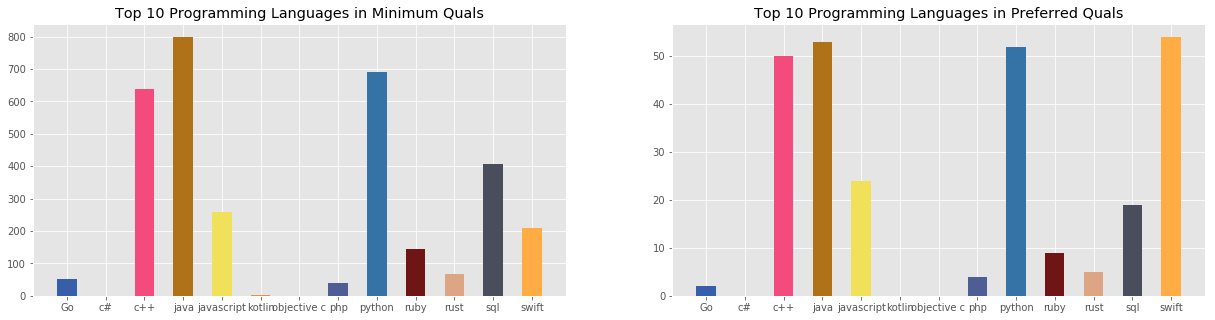

In [14]:
min_labels = list(min_lang_reqs.keys())
min_values = list(min_lang_reqs.values())
min_colors = [lang_colors[k] for k, v in min_lang_reqs.items()]

pref_labels = list(pref_lang_reqs.keys())
pref_values = list(pref_lang_reqs.values())
pref_colors = [lang_colors[k] for k, v in pref_lang_reqs.items()]


plt.figure(figsize=(21, 5))

plt.subplot(121)
plt.bar(min_labels, min_values, color=min_colors, width=0.5)
plt.title('Top 10 Programming Languages in Minimum Quals')

plt.subplot(122)
plt.bar(pref_labels, pref_values, color=pref_colors, width=0.5)
plt.title('Top 10 Programming Languages in Preferred Quals')

plt.show()

## 5. Top Demanding Skills from Job Descriptions

Extract keywords and create word clouds from the following:

● Minimum Qualifications

● Preferred Qualifications

● Responsibilities

### Word frequency matrix

For each job, we create a wfm (word frequency matrix) and store all results in a dict.

In [15]:
def import_terms(tokenizer: nltk.tokenize.MWETokenizer, term_file_path: str):
    """ Import all user-defined untokenizable terms from a file into nltk MWETokenizer.
    :param tokenizer: nltk MWETokenizer instance.
    :param text_file_path: path to the file.
    """
    with open(term_file_path, 'r') as f:
        for line in f:
            tokenizer.add_mwe(line.strip().split())

In [16]:
def create_word_freq_dict(tokenizer, df, col_name, lowercase=True, preserve_case_words=[]):
    """ Create a word frequency dict
    :param tokenizer: nltk MWETokenizer.
    :param df: source pandas dataframe.
    :param col_name: name of the column to create wfm from.
    :param lowercase: convert all tokens into lowercase.
    :param preserve_case_words: words that should preserve their cases.
    :return: a word frequency dict (dict of dict, separated by job indices).
    """
    freq = {}
    
    for i, col in enumerate(df[col_name]):
        if type(col) is not str:
            continue
        freq[i] = {}
        
        words = tokenize(tokenizer, col, lowercase=True, preserve_case_words=preserve_case_words)
        for word in words:
            if word in freq:
                freq[i][word] += 1
            else:
                freq[i][word] = 1
                
    return freq

In [17]:
def create_wfm(word_frequency_dict: dict):
    """ Create word frequency matrix from the specified word frequency dict """
    dwf_list = [pandas.DataFrame(list(freq.values()), index=freq.keys()) for freq in word_frequency_dict.values()]
    wfm = pandas.concat(dwf_list, axis=1)
    wfm = np.transpose(wfm).fillna(0)
    wfm.index = word_frequency_dict.keys()
    return wfm

In [18]:
# Initialize nltk MWETokenizer.
tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
import_terms(tokenizer, 'cs_terms.txt')

# Words that 
preserve_case_words = ['Go', '.Net', '.NET']

min_qual_wfd = create_word_freq_dict(tokenizer, df, 'minimum_qual', True, preserve_case_words)
pref_qual_wfd = create_word_freq_dict(tokenizer, df, 'preferred_qual', True, preserve_case_words)
resp_qual_wfd = create_word_freq_dict(tokenizer, df, 'responsibilities', True, preserve_case_words)

list(min_qual_wfd[0].items())[0:10]

[('years', 1),
 ('experience', 1),
 ('supporting', 1),
 ('or', 1),
 ('deploying', 1),
 ('application', 1),
 ('software', 1),
 ('for', 1),
 ('internal', 1),
 ('and', 1)]

In [19]:
min_qual_wfm = create_wfm(min_qual_wfd)
pref_qual_wfm = create_wfm(pref_qual_wfd)
resp_wfm = create_wfm(resp_qual_wfd)

# Row: job, Column: word frequency
pref_qual_wfm.head(5)

C:\Users\Anita\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,,'d,'ll,'re,'s,**preferred,*apple,*completed,*development,*experience,...,¢exposure,¢familiarity,¢in,¢machine,¢position,¢prior,¢seek,¢using,¢working,¢your
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply TF-IDF Transformation to Word Frequency Matrices

In [20]:
def create_tfm(wfm):
    tfm = wfm.copy()
    for i in range(0, len(tfm)):
        tfm.iloc[i] = tfm.iloc[i] / tfm.iloc[i].sum()
    return tfm

min_qual_tfm = create_tfm(min_qual_wfm)
pref_qual_tfm = create_tfm(pref_qual_wfm)
resp_tfm = create_tfm(resp_wfm)

min_qual_tfm.head()

,,'d,'ll,'re,'s,'the,'ve,**minimum,*nix,",as",...,¢expert,¢highly,¢in-depth,¢outstanding,¢strong,¢vfx,¢willing,¦etc,âµvision,ï£¿watch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
min_qual_df = (min_qual_wfm > 0).sum()
pref_qual_df = (pref_qual_wfm > 0).sum()
resp_df = (resp_wfm > 0).sum()

In [22]:
N = len(df)
N

2157

In [23]:
def create_tfidfm(tfm, N, df):
    tfidfm = tfm.copy()
    for i in range(0, len(tfidfm)):
        # Add 0.01 to not completely ignore irregular words.
        tfidfm.iloc[i] = tfidfm.iloc[i] * np.log10(N / df) + 0.01
    return tfidfm
    
min_qual_tfidfm = create_tfidfm(min_qual_tfm, N, min_qual_df)
pref_qual_tfidfm = create_tfidfm(pref_qual_tfm, N, pref_qual_df)
resp_tfidfm = create_tfidfm(resp_tfm, N, resp_df)

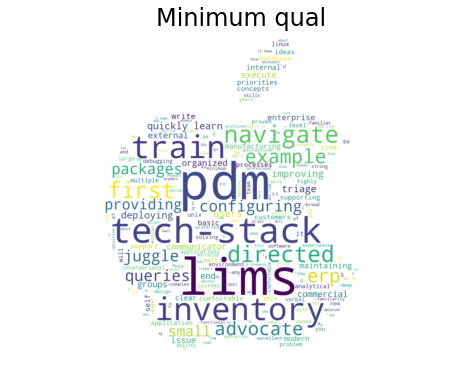

In [24]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
G = np.array(Image.open('apple-icon.png'))
tfidf_dict = min_qual_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])

plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Minimum qual',size=24)
plt.show()

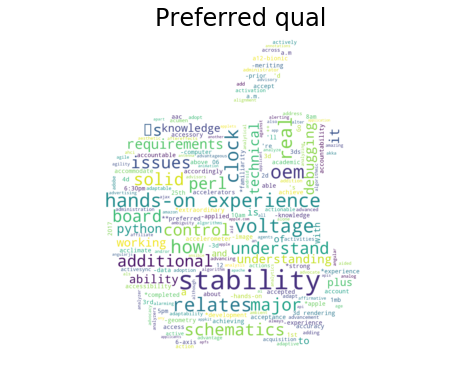

In [25]:
tfidf_dict = pref_qual_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])

plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Preferred qual',size=24)
plt.show()

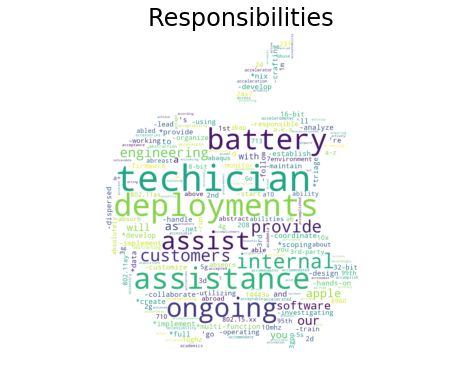

In [26]:
tfidf_dict = resp_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])

plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Responsibilities',size=24)
plt.show()

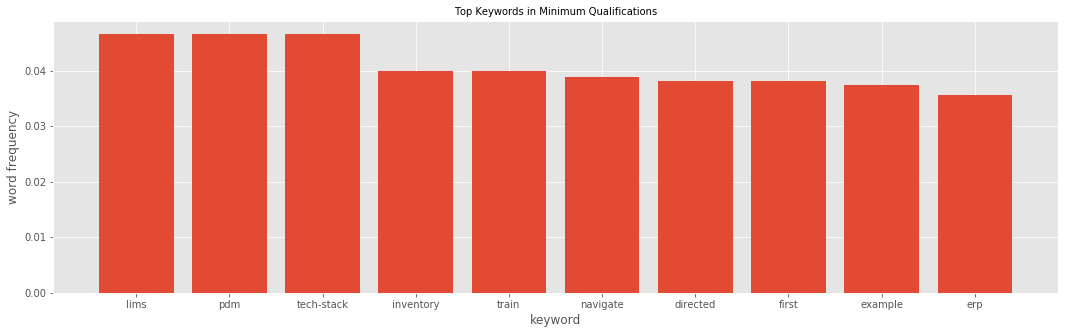

In [27]:
font_path = r'DejaVuSans.ttf'
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Minimum Qualifications'
plot_tfidf_bar(min_qual_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

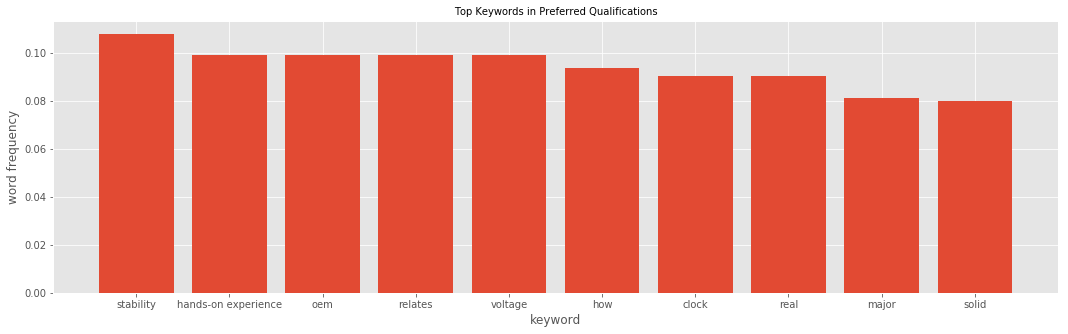

In [28]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Preferred Qualifications'
plot_tfidf_bar(pref_qual_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

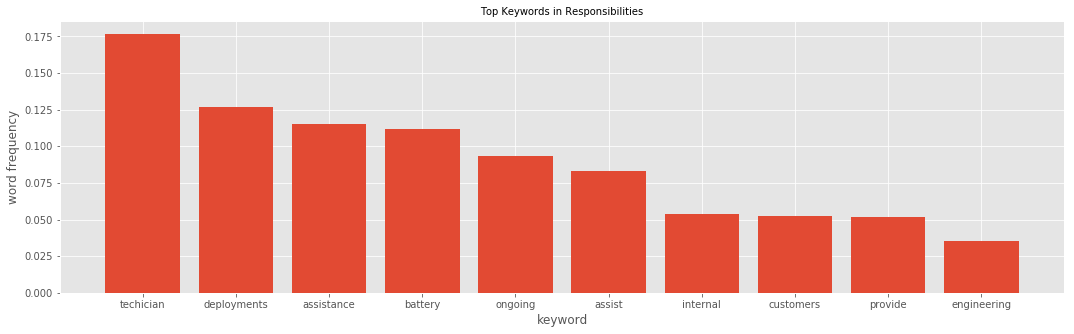

In [29]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Responsibilities'
plot_tfidf_bar(resp_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

In [3]:
loc = []
for a in df['location']:
    loc.append(a)

In [5]:
loc_dic={}
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
geolocator = Nominatim()
for a in loc:
    try:
        if a in loc_dic:
            continue
        location = geolocator.geocode(a)
        if type(a) is str:
            loc_dic[a]=(location.latitude, location.longitude)
    except GeocoderTimedOut as e:
        print("noooooooooooooooooo")

C:\Users\Anita\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


AttributeError: 'NoneType' object has no attribute 'latitude'

In [56]:
location = geolocator.geocode('Paris, France')
print(location.latitude, location.longitude)

48.8566101 2.3514992


In [77]:
del loc_dic['Paris, Paris Region, France']

In [78]:
loc_dic['Paris, Paris Region, France']=(48.8566101,2.3514992)

In [79]:
loc_dic

{'Amsterdam, Holland, Netherlands': (52.3745403, 4.89797550561798),
 'Auckland, Auckland, New Zealand': (-36.8534665, 174.7655514),
 'Austin, Texas, United States': (30.2711286, -97.7436995),
 'Beaverton, Oregon, United States': (45.4871723, -122.8037804),
 'Beijing, Beijing, China': (39.906217, 116.3912757),
 'Bengaluru, Karnataka, India': (12.9791198, 77.5912997),
 'Cambridge, Cambridgeshire, United Kingdom': (52.2034823, 0.1235817),
 'Copenhagen, Copenhagen, Denmark': (55.6867243, 12.5700724),
 'Cork, County Cork, Ireland': (51.8979282, -8.4705806),
 'Culver City, California, United States': (34.0211224, -118.3964665),
 'Cupertino, California, United States': (37.3228934, -122.0322895),
 'Dallas, Texas, United States': (32.7762719, -96.7968559),
 'Denver, Colorado, United States': (39.7392364, -104.9848623),
 'Dusseldorf, North Rhine-Westphalia, Germany': (51.2254018, 6.7763137),
 'Gurgaon, Haryana, India': (28.4646148, 77.0299194),
 'Haifa, Israel': (32.8191218, 34.9983856),
 'Herz

In [80]:
key_arr=[]
long=[] 
lati=[]
for key, value in loc_dic.items():
    key_arr.append(key)
    long.append(loc_dic[key][1])
    lati.append(loc_dic[key][0])

In [81]:
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame

In [82]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(long, lati)]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(key_arr, crs=crs, geometry=geometry)

In [83]:
gdf

,0,geometry
0,"Santa Clara Valley (Cupertino), California, Un...",POINT (-121.9551744 37.3541132)
1,"Austin, Texas, United States",POINT (-97.74369950000001 30.2711286)
2,"Hyderabad, Telangana, India",POINT (78.4746286 17.3616079)
3,"Dallas, Texas, United States",POINT (-96.7968559 32.7762719)
4,"Zurich, Zurich, Switzerland",POINT (8.5414061 47.3769434)
5,"Herzliya, Israel",POINT (34.8469023 32.1656255)
6,"Singapore, Singapore, Singapore",POINT (103.878446863736 1.3408528)
7,"Prague, Bohemia, Czechia",POINT (14.628005 49.9954522)
8,"Seattle, Washington, United States",POINT (-122.3300624 47.6038321)
9,"Recife, Pernambuco, Brazil",POINT (-34.8781517 -8.064193100000001)


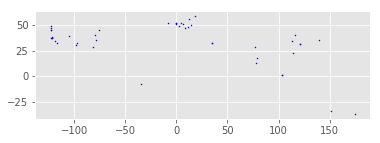

In [84]:
gdf.plot(marker='o', color='b', markersize=1)

In [85]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

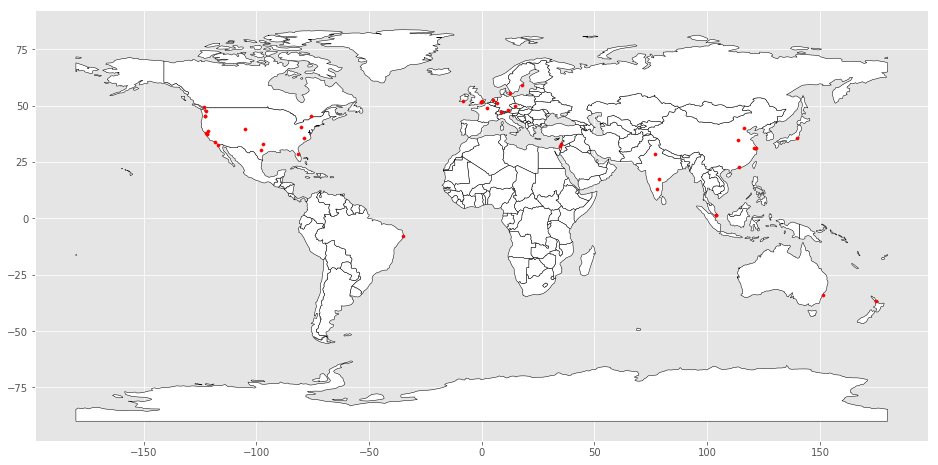

In [86]:
base = world.plot(color='white', edgecolor='black', figsize=(16, 10))
gdf.plot(ax = base,marker='o', color='r', markersize=10)